# Triplet loss Test
We will make a better implementation of the Triplet loss using tensorflow

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from configs.SimulatedData import Proposed
from sklearn.decomposition import PCA
from dataset.tf_pipeline import make_train_valid_dset, convert_dataframe_to_tensorflow_sequences

2024-05-07 08:17:18.681731: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 08:17:18.809235: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-07 08:17:19.397075: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2024-05-07 08:17:19.397132: W tensorflow/compiler/xla/stream_exec

In [2]:
config = Proposed()

D1_PATH = "data/simulated_dataset/01 - Source Domain.h5"
D2_PATH = "data/simulated_dataset/output_noise/0.75.h5"
# D3_PATH = "data/simulated_dataset/amplitude_shift/3.5_3.5.h5"

SEQUENCE_LENGTH = config.sequence_lenght_in_sample
GRANUARITY = config.granularity
OVERLAP = config.overlap
BS = 64 # config.batch_size
EPOCHS = 25 #config.epochs
NUM_SEQUENCE_TO_GENERATE = config.met_params.sequence_to_generate
STYLE_VECTOR_SIZE = 8
TRIPLET_R= 1.5

In [3]:
df_d1= pd.read_hdf(D1_PATH).astype(np.float32)
df_d2= pd.read_hdf(D2_PATH).astype(np.float32)
# df_d3= pd.read_hdf(D3_PATH).astype(np.float32)

# Reducing the dataset size to make the training faster.
df_d1 = df_d1.loc[:int(df_d1.shape[0]/5)]
df_d2 = df_d2.loc[:int(df_d2.shape[0]/5)]
# df_d3 = df_d3.loc[:int(df_d2.shape[0]/5)]

df_d1 = df_d1.drop(columns=['labels'])
df_d2 = df_d2.drop(columns=['labels'])
# df_d3 = df_d3.drop(columns=['labels'])

N_FEAT = df_d1.shape[1]

In [4]:
def make_style_encoder(seq_length:int, n_feat:int, vector_output_shape:int):
    _input = tf.keras.Input((seq_length, n_feat))

    x = tf.keras.layers.Conv1D(128, 5, 2, padding='same')(_input)    
    x = tf.keras.layers.Conv1D(256, 5, 1, padding='same')(x)
    x = tf.keras.layers.Conv1D(256, 5, 1, padding='same')(x)
    # x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(256, 5, 2, padding='same')(x)
    x = tf.keras.layers.Conv1D(512, 5, 1, padding='same')(x)
    x = tf.keras.layers.Conv1D(512, 5, 1, padding='same')(x)
    # x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.Dense(50)(x)
    x = tf.keras.layers.Dense(vector_output_shape)(x)

    model = tf.keras.Model(_input, x)
    return model

In [5]:
style_encoder = make_style_encoder(SEQUENCE_LENGTH, df_d1.shape[1], STYLE_VECTOR_SIZE)
opt_style_encoder = tf.keras.optimizers.Adam()

2024-05-07 08:17:21.019201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 08:17:21.744013: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22271 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:2d:00.0, compute capability: 8.6


In [6]:
style_encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 7)]           0         
                                                                 
 conv1d (Conv1D)             (None, 32, 128)           4608      
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 256)           164096    
                                                                 
 conv1d_2 (Conv1D)           (None, 32, 256)           327936    
                                                                 
 conv1d_3 (Conv1D)           (None, 16, 256)           327936    
                                                                 
 conv1d_4 (Conv1D)           (None, 16, 512)           655872    
                                                                 
 conv1d_5 (Conv1D)           (None, 16, 512)           131123

# Batch Selection:
In this kind of losses, we have to select a an *Anchor*, a *positive* and a *negative*. To be sure that we have all these things in hand, we will make a batch Selector

In [7]:
def train_test_split(dataset:pd.DataFrame):
    train_split = .7
    df_size = dataset.shape[0]

    train_idx = int(train_split* df_size)

    train_df = dataset.loc[:train_idx]
    valid_df = dataset.loc[train_idx:]

    return train_df, valid_df

def create_global_dataset(datasets:list) -> tf.data.Dataset:
    # Give a label to each dataset (where they come from)
    train_datasets = []
    valid_datasets = []

    for i in range(len(datasets)):
        datasets[i]['labels']= i
        _train, _valid = train_test_split(datasets[i])

        train_datasets.append(_train)
        valid_datasets.append(_valid)

    _df_train= pd.concat(train_datasets)
    _df_valid= pd.concat(valid_datasets)

    dset_train = convert_dataframe_to_tensorflow_sequences(
        _df_train, 
        SEQUENCE_LENGTH,
        GRANUARITY,
        int(OVERLAP* SEQUENCE_LENGTH), 
        False
    )

    dset_valid = convert_dataframe_to_tensorflow_sequences(
        _df_valid, 
        SEQUENCE_LENGTH,
        GRANUARITY,
        int(OVERLAP* SEQUENCE_LENGTH), 
        False
    )

    dset_train= dset_train.map(lambda seq: (seq[:, :-1], seq[-1, -1]),  num_parallel_calls=tf.data.AUTOTUNE)#.cache()
    dset_valid= dset_valid.map(lambda seq: (seq[:, :-1], seq[-1, -1]),  num_parallel_calls=tf.data.AUTOTUNE)#.cache()

    dset_train = dset_train.shuffle(20000)
    dset_valid = dset_valid.shuffle(20000)


    dset_train = dset_train.batch(BS, drop_remainder=True)
    dset_valid = dset_valid.batch(256, drop_remainder=True)

    return dset_train, dset_valid

dset_train, dset_valid= create_global_dataset((df_d1, df_d2))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [8]:
from datetime import datetime

start = datetime.now()
test_sequences, test_labels = next(iter(dset_train))
stop = datetime.now()

print(stop- start)

test_labels

0:00:01.663473


<tf.Tensor: shape=(64,), dtype=float64, numpy=
array([0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.])>

In [9]:
def _pairwise_distance(embeddings):
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.linalg.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 0) - 2.0 * dot_product + tf.expand_dims(square_norm, 1)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    return distances

In [10]:
def get_positives(labels):
    # will assign 1 where this is a positive 
    positive_mask = np.array([ tf.cast(labels == l, tf.float32) for l in labels])
    positive_mask = positive_mask - np.identity(positive_mask.shape[0])
    return positive_mask

def get_negative(labels):
    neg_labels= np.array([ tf.cast(labels != l, tf.float32) for l in labels])
    return neg_labels

In [11]:
def l2(x:tf.Tensor, y:tf.Tensor):
    diff = tf.square(y- x)
    _distance = tf.reduce_sum(diff, axis=-1)
    return _distance

In [12]:
# test_sequences, test_labels = next(iter(dset_train))

# embeddings = style_encoder(test_sequences)

# # test_labels = tf.constant([0.,0.,0.,1.,1.,0.])

# distances= _pairwise_distance(embeddings)

# # Select Positives:
# pos_mask= get_positives(test_labels)

# pos_mask
# positive_distance = distances* pos_mask
# positive_index= tf.argmax(positive_distance, axis=1)
# pos_embedding = tf.gather(embeddings, positive_index)

# # Select Negatives:
# neg_mask= get_negative(test_labels)
# neg_distances = distances*neg_mask*-1
# neg_indexes = tf.argmin(neg_distances, axis=1)
# neg_embeddings= tf.gather(embeddings, neg_indexes)

# positive_distances= l2(embeddings, pos_embedding)
# negative_distances= l2(embeddings, neg_embeddings)

# # print("anchor:")
# # print(embeddings)

# # print("positive emb:")
# # print(pos_embedding)
# # print('neg emb:')
# # print(neg_embeddings)

# # print("positive distance:")
# # print(positive_distances.numpy())
# # print("negative distance:")
# # print(negative_distances.numpy())

# # print("triplet")
# # prout = margin+ positive_distances - negative_distances 
# # print(prout.numpy())

# loss = tf.reduce_mean(tf.maximum(TRIPLET_R+ positive_distances - negative_distances, 0))


In [13]:
def get_triplet_loss(embeddings, labels):
    # start = datetime.now()
    distances= _pairwise_distance(embeddings)
    # stop = datetime.now()
    # print("pair_ distance", stop-start)

    # Select Positives:
    # start = datetime.now()
    pos_mask= get_positives(labels)
    # stop = datetime.now()
    # print(stop-start)
    # print(pos_mask.shape)

    positive_distance = distances* pos_mask
    positive_index= tf.argmax(positive_distance, axis=1)

    # start = datetime.now()
    pos_embedding = tf.gather(embeddings, positive_index)
    # stop = datetime.now()
    # print("pos embedding", stop-start)
    # print(pos_embedding.shape)

    # Select Negatives:
    # start = datetime.now()
    neg_mask= get_negative(labels)
    # stop = datetime.now()
    # print('get negarive', stop-start)
    # print(neg_mask.shape)
    
    neg_distances = distances*neg_mask*-1
    neg_indexes = tf.argmin(neg_distances, axis=1)
    
    neg_embeddings= tf.gather(embeddings, neg_indexes)

    positive_distances= l2(embeddings, pos_embedding)
    negative_distances= l2(embeddings, neg_embeddings)

    loss = tf.reduce_mean(tf.maximum(TRIPLET_R+ positive_distances - negative_distances, 0))

    return loss

In [14]:
def plot_lattent_space(embeddings, labels, title=''):
    reducer= PCA(n_components=2)
    reduced_embeddings= reducer.fit_transform(embeddings)

    plt.figure(figsize=(18, 10))
    plt.title(title)
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels)
    plt.grid()
    plt.show()  

In [15]:
times= []

# for i in range(25):
#     start = datetime.now()
#     next(iter(dset_train))
#     stop = datetime.now()

#     print(f'\r{i}; {stop- start}', end="")
#     times.append(stop-start)

# print()
# print(np.mean(times))

# bench the loss function
# times = []
# for i, (sequences, labels) in enumerate(dset_train.take(25)):
#     embeddings= style_encoder(sequences, training=False)

#     start = datetime.now()
#     triplet_loss= get_triplet_loss(embeddings, labels)
#     stop = datetime.now()
#     print(f'\r{i}; {stop- start}', end="")
#     times.append(stop-start)

print(np.mean(times))

nan


/home/henri/anaconda3/envs/tf2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/henri/anaconda3/envs/tf2/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


tf.Tensor(
[0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0.
 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0.
 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0.
 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1.
 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1.], shape=(256,), dtype=float64)


2024-05-07 08:17:25.846498: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2024-05-07 08:17:26.696251: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


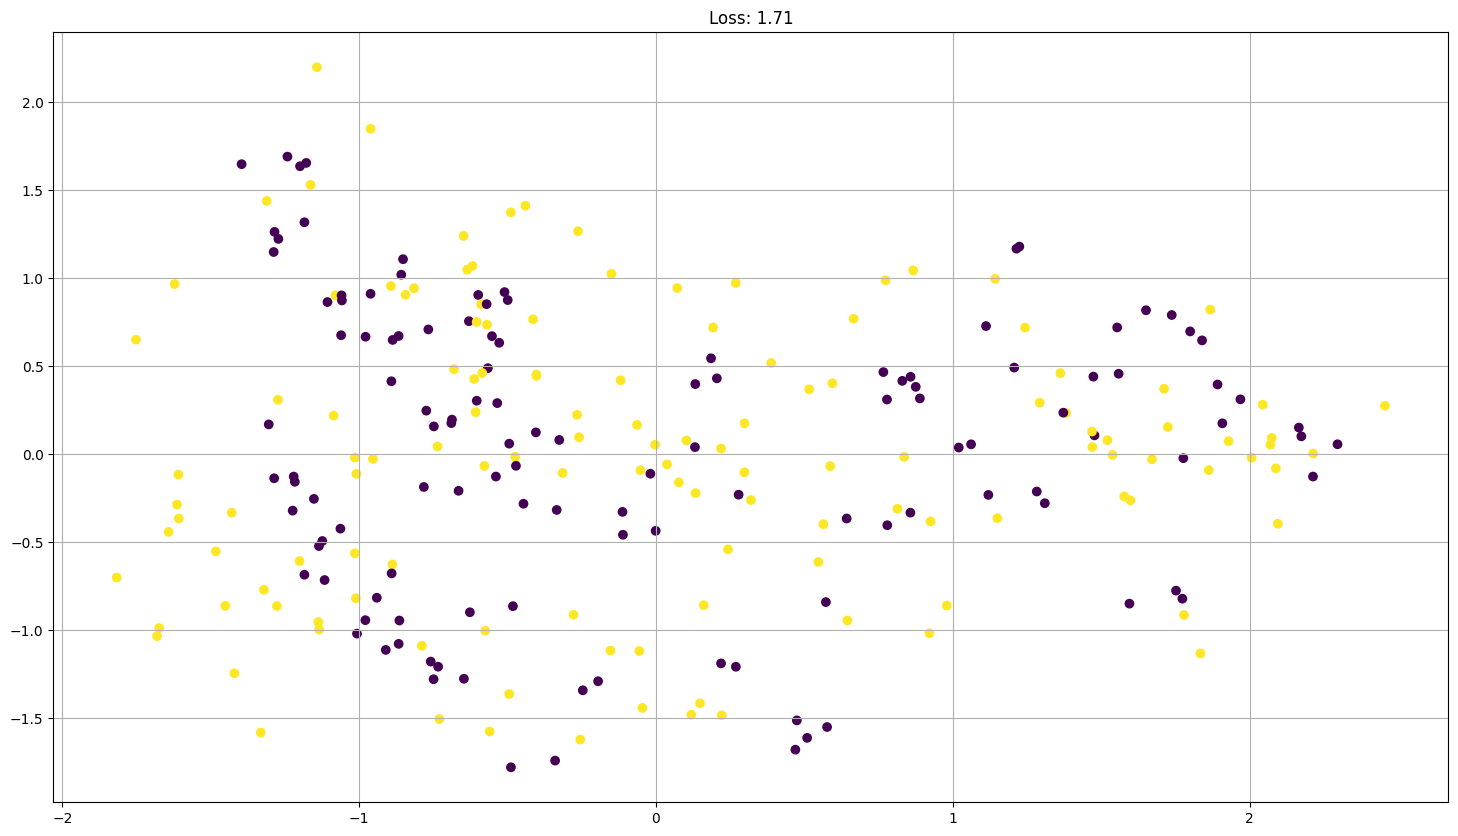

In [16]:
valid_sequences, labels = next(iter(dset_valid))
print(labels)

valid_emb = style_encoder(valid_sequences, training=False)
triplet_loss= get_triplet_loss(valid_emb, labels)
plot_lattent_space(valid_emb, labels, f"Loss: {triplet_loss:0.2f}")

In [17]:
met_triplet_loss_train = tf.keras.metrics.Mean(name="Train Triplet loss")
met_triplet_loss_valid = tf.keras.metrics.Mean(name="Valid Triplet loss")

def train_step(sequences, labels):
    with tf.GradientTape() as tape:
        embeddings= style_encoder(sequences, training=True)
        triplet_loss= get_triplet_loss(embeddings, labels)
        
    style_encoding_grads= tape.gradient(triplet_loss, style_encoder.trainable_variables)
    opt_style_encoder.apply_gradients(zip(style_encoding_grads, style_encoder.trainable_variables))

    met_triplet_loss_train(triplet_loss)


def valid_step(sequences, labels):
    embeddings= style_encoder(sequences)
    triplet_loss= get_triplet_loss(embeddings, labels)

    met_triplet_loss_valid(triplet_loss)


In [18]:
def train():
    train_losses, valid_losses = [], []

    for e in range(EPOCHS):
        met_triplet_loss_train.reset_state()
        met_triplet_loss_valid.reset_state()
        
        for i, (sequences, labels) in enumerate(dset_train):
            train_step(sequences, labels)
            print(f"\r e {e}/{EPOCHS}; {i}: {met_triplet_loss_train.result():0.2f}                  ", end="")
        print()
        for vi, (valid_seq, valid_labels) in enumerate(dset_valid.take(150)):
            valid_step(valid_seq, valid_labels) 
            print(f"\r[VALID] e {e}/{EPOCHS}; {vi}: {met_triplet_loss_valid.result():0.2f}                  ", end="")
                    
    
        print()

        train_losses.append(met_triplet_loss_train.result())
        valid_losses.append(met_triplet_loss_valid.result())
        
    return train_losses, valid_losses

In [19]:
train_loss, valid_loss= train()

2024-05-07 08:17:29.200126: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x561af27ed410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-07 08:17:29.200154: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-05-07 08:17:29.204589: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-07 08:17:29.323046: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 e 0/25; 272: 162.72                  
[VALID] e 0/25; 28: 2.58                  
 e 1/25; 272: 1.95                  
[VALID] e 1/25; 28: 1.68                  
 e 2/25; 272: 1.58                  
[VALID] e 2/25; 28: 1.57                  
 e 3/25; 272: 1.52                  
[VALID] e 3/25; 28: 1.44                  
 e 4/25; 272: 1.53                  
[VALID] e 4/25; 28: 1.59                  
 e 5/25; 272: 1.51                  
[VALID] e 5/25; 28: 1.47                  
 e 6/25; 272: 1.40                  
[VALID] e 6/25; 28: 1.64                  
 e 7/25; 272: 1.30                  
[VALID] e 7/25; 28: 1.21                  
 e 8/25; 272: 1.04                  
[VALID] e 8/25; 28: 0.97                  
 e 9/25; 272: 0.92                  
[VALID] e 9/25; 28: 0.75                  
 e 10/25; 272: 0.90                  
[VALID] e 10/25; 28: 0.83                  
 e 11/25; 272: 0.77                  
[VALID] e 11/25; 28: 0.35                  
 e 12/25; 272: 0.51               

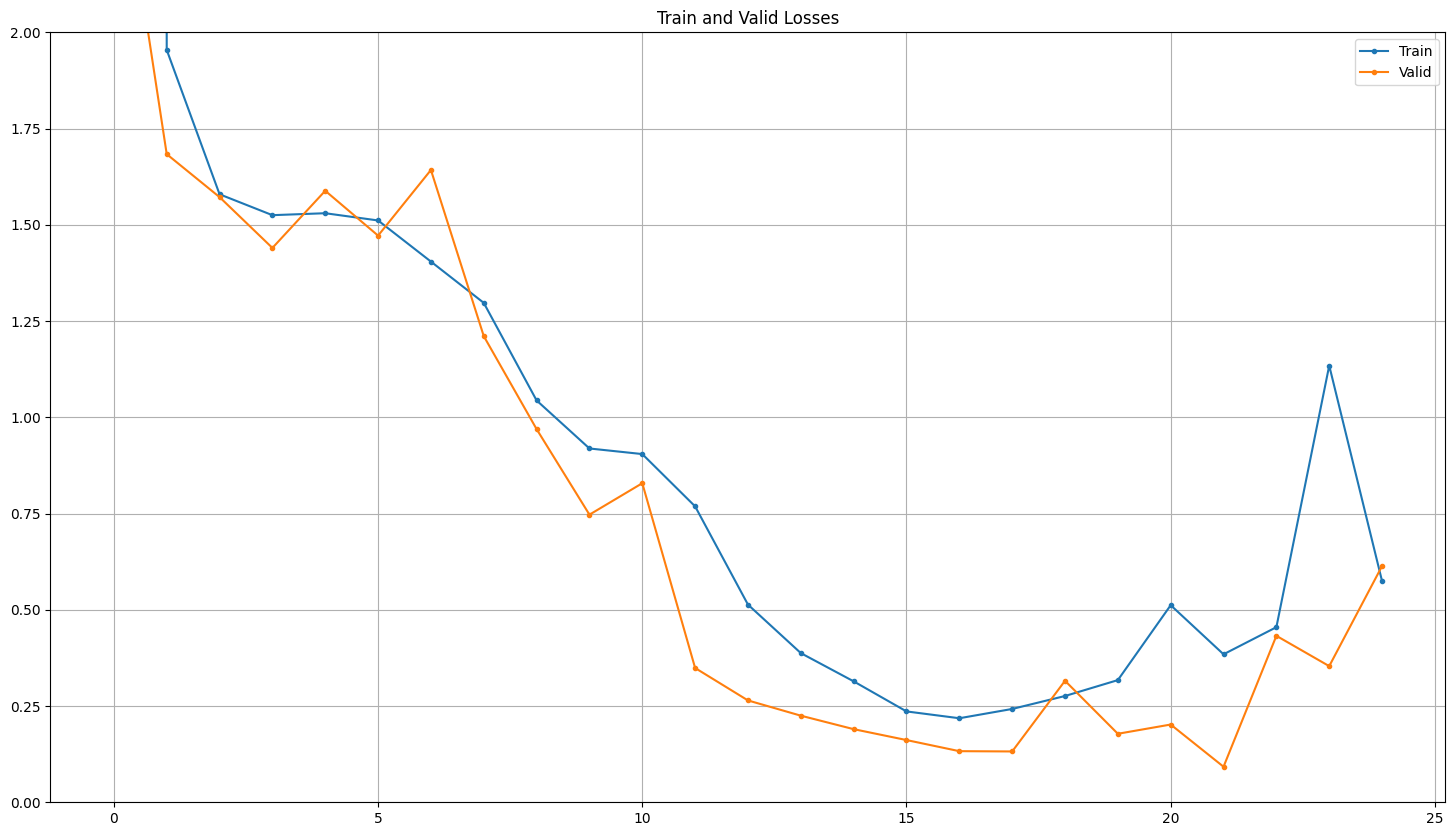

In [22]:
plt.figure(figsize=(18, 10))
plt.title("Train and Valid Losses")
plt.plot(train_loss, ".-", label="Train")
plt.plot(valid_loss, ".-", label="Valid")
plt.ylim((0, 2))
plt.grid()
plt.legend()

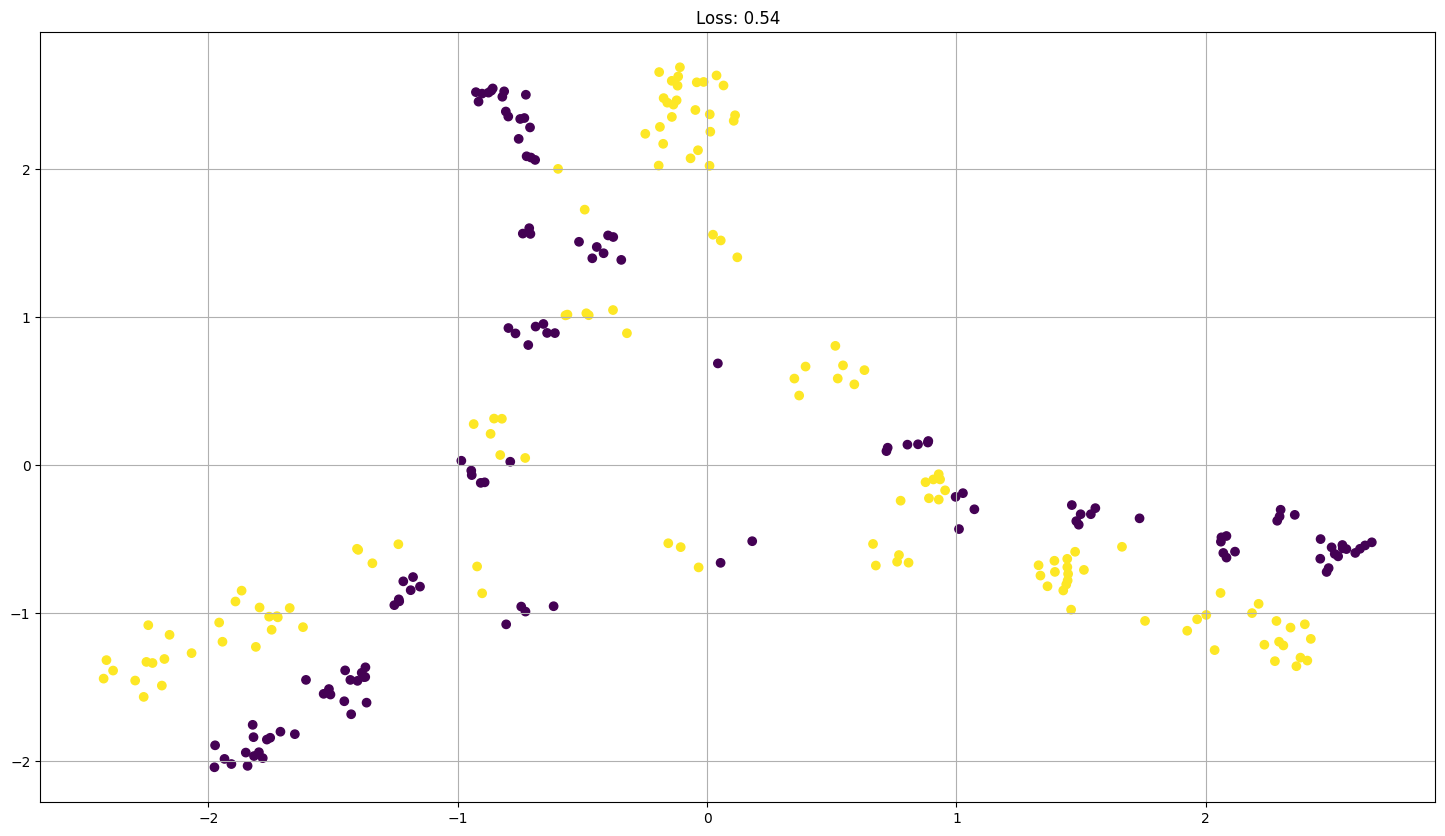

In [21]:
valid_embeddings= style_encoder(valid_sequences)
loss= get_triplet_loss(valid_embeddings, labels)
plot_lattent_space(valid_embeddings, labels, f"Loss: {loss:0.2f}")